## The problem

- Walking around in a 2D maze
- This is a toy problem, we will make it more challenging later

In [1]:
import gym
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [2]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf

In [3]:
tf.__version__

'2.8.0'

In [4]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2022-03-24_10-20-06_629923_7949/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-24_10-20-06_629923_7949/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-24_10-20-06_629923_7949',
 'metrics_export_port': 61995,
 'gcs_address': '127.0.0.1:56690',
 'node_id': '5758aefbba83c186c210a3ea026aeaac1d61d62ca8335c19594309d5'}

In [5]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [6]:
class MazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.ylen*self.xlen)
    
    def reset(self, seed=42):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        if seed is not None:
            np.random.seed(seed)
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self):
        return self.player[0] + self.ylen*self.player[1] # TODO: FIX TO MATCH THE ONE BELOW SO IT GOES ROWS FIRST
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [7]:
# BY DEFAULT USES SEED 22
me = MazeEnvironment({})
me.reset()
me.render()

P...X
XX...
X...X
X....
.X..E


In [8]:
# sorted(trainer.config)

In [103]:
trainer_config = {
    "num_workers": 1,
    # "model": {
    #     "fcnet_hiddens": [64, 64],
    #     "fcnet_activation": "relu",
    # },
    "evaluation_num_workers": 1,
    # "evaluation_interval" : 1,
    "create_env_on_driver" : True,
    # "evaluation_config": {
    #     "render_env": True,
    # },
    "log_level" : "ERROR"
    # "framework" : "torch" # default is tf
}

trainer = DQNTrainer(trainer_config, env=MazeEnvironment)

In [104]:
rewards = []
for episode in range(10):
    print(episode)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9


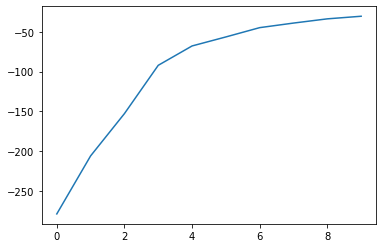

In [105]:
plt.plot(rewards);

In [12]:
out;

In [13]:
me = MazeEnvironment({})
obs = me.reset() # BY DEFAULT USES SEED 22
me.render()

P...X
XX...
X...X
X....
.X..E


In [14]:
action = trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

.P..X
XX...
X...X
X....
.X..E

action: right
reward: -7
done: False


try with a fresh trainer to make sure it does badly:

In [33]:
new_trainer = DQNTrainer(trainer_config, env=MazeEnvironment)
me = MazeEnvironment({})
obs = me.reset() 
me.render()

P...X
XX...
X...X
X....
.X..E


In [47]:
action = new_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

P...X
XX...
X...X
X....
.X..E

action: down
reward: -8
done: False


back to orig trainer:

In [15]:
print(trainer.evaluation_workers)

In [16]:
trainer.config["evaluation_config"]["explore"]

False

In [17]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -28.0,
  'episode_reward_min': -28.0,
  'episode_reward_mean': -28.0,
  'episode_len_mean': 8.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0],
   'episode_lengths': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.11820852020640431,
   'mean_inference_ms': 0.47563623498987273,
   'mean_action_processing_ms': 0.021322273913724925,
   'mean_env_wait_ms': 0.04535545537501205,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [18]:
policy = trainer.get_policy()
model = policy.model

In [19]:
from ray.rllib.models.preprocessors import get_preprocessor 
obs_space = me.observation_space
preprocessor = get_preprocessor(obs_space)(obs_space)
observations = me.reset()
transformed = preprocessor.transform(observations).reshape(1, -1)

In [20]:
transformed

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
model_output, _ = model({"obs": transformed})

In [22]:
model_output

<tf.Tensor 'model/fc_out/Tanh:0' shape=(1, 256) dtype=float32>

In [23]:
q_values = model.get_q_value_distributions(model_output)

In [24]:
sess = policy.get_session()

In [25]:
q_values

[<tf.Tensor 'BiasAdd_1:0' shape=(1, 4) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_10:0' shape=(1, 4, 1) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_1_1:0' shape=(1, 4, 1) dtype=float32>]

In [26]:
sess.run(q_values[0])

array([[-2.1526077, -2.128568 ,  5.6372466, -2.09145  ]], dtype=float32)

In [27]:
sess.run(q_values[1])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [28]:
sess.run(q_values[2])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [29]:
ac = trainer.compute_single_action(input_dict={"obs": observations}, explore=False)
ac

2

In [30]:
action_names[ac]

'right'

In [31]:
action_distribution = policy.dist_class(model_output, model) 
sample = action_distribution.sample()
sess.run(sample)

array([53])

To dos:

- [X] figure out how to extract model
- [X] try to get reasonable results on maze
- [ ] then try to make the levels random and see what happens
- [ ] implement some feature vectors

In [71]:
class RandomMazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        
        # show entire state, not just nearby the player
        self.observation_space = gym.spaces.Dict({
            "player" : gym.spaces.Discrete(self.ylen*self.xlen),
            "walls" : gym.spaces.MultiBinary(self.ylen*self.xlen)
        })
    
    def reset(self, seed=None):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        if seed is not None:
            np.random.seed(seed)
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        
        self.wallsstate = np.array(self.walls.flatten(), dtype='int8')
        
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self): # SWAPPED FROM THE ABOVE ONE
        # make the observation into the entire state??
        playerstate = self.player[1] + self.xlen*self.player[0]
        obsdict = {
            "player" : playerstate,
            "walls" : self.wallsstate
        }
        return obsdict
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [72]:
rme = RandomMazeEnvironment({})

In [109]:
rme_dqn_trainer = DQNTrainer(trainer_config, env=RandomMazeEnvironment)

In [138]:
print(rme_dqn_trainer.get_policy().model)

In [110]:
rme_dqn_rewards = []
for episode in range(10):
    print(episode)
    out = rme_dqn_trainer.train();
    rme_dqn_rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9


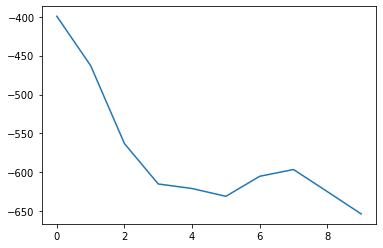

In [111]:
plt.plot(rme_dqn_rewards);

In [113]:
rme = RandomMazeEnvironment({})
obs = rme.reset() 
rme.render()

PX.X.
...X.
..X..
.....
..XXE


In [127]:
action = rme_dqn_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = rme.step(action)
obs = res[0]
rme.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

PX.X.
...X.
..X..
.....
..XXE

action: right
reward: -8
done: False


In [83]:
rme.reset()

{'player': 0,
 'walls': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0], dtype=int8)}

In [84]:
rme.render()

P..X.
.....
....X
.....
...XE


In [85]:
rme.step(1)
rme.step(2)
rme.step(2)

({'player': 7,
  'walls': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0], dtype=int8)},
 -5,
 False,
 {'player pos': (1, 2)})

In [76]:
rme.render()

....X
..P..
X...X
X....
....E


In [61]:
rme.get_observation()

{'player': 0,
 'walls': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=int8)}